# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
environment_enable_multi_backend_download = \
    os.environ.get("RADARCOVID_REPORT__ENABLE_MULTI_BACKEND_DOWNLOAD")
if environment_enable_multi_backend_download:
    report_backend_identifiers = None
else:
    report_backend_identifiers = [report_backend_identifier]

report_backend_identifiers

In [6]:
environment_invalid_shared_diagnoses_dates = \
    os.environ.get("RADARCOVID_REPORT__INVALID_SHARED_DIAGNOSES_DATES")
if environment_invalid_shared_diagnoses_dates:
    invalid_shared_diagnoses_dates = environment_invalid_shared_diagnoses_dates.split(",")
else:
    invalid_shared_diagnoses_dates = []

invalid_shared_diagnoses_dates

['2020-10-30', '2020-12-02', '2020-12-05']

### COVID-19 Cases

In [7]:
report_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=report_backend_identifier)

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe_from_ecdc():
    return pd.read_csv(
        "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")

confirmed_df_ = download_cases_dataframe_from_ecdc()

In [9]:
confirmed_df = confirmed_df_.copy()
confirmed_df = confirmed_df[["dateRep", "cases", "geoId"]]
confirmed_df.rename(
    columns={
        "dateRep":"sample_date",
        "cases": "new_cases",
        "geoId": "country_code",
    },
    inplace=True)
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases,country_code
25835,2020-12-14,316,HN
25560,2020-12-14,0,VA
25290,2020-12-14,74,HT
27094,2020-12-14,6189,ID
0,2020-12-14,746,AF


In [10]:
def sort_source_regions_for_display(source_regions: list) -> list:
    if report_backend_identifier in source_regions:
        source_regions = [report_backend_identifier] + \
            list(sorted(set(source_regions).difference([report_backend_identifier])))
    else:
        source_regions = list(sorted(source_regions))
    return source_regions

In [11]:
report_source_regions = report_backend_client.source_regions_for_date(
    date=extraction_datetime.date())
report_source_regions = sort_source_regions_for_display(
    source_regions=report_source_regions)
report_source_regions

['ES', 'DE', 'DK', 'HR', 'IE', 'IT', 'LV', 'NL', 'PL']

In [12]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
confirmed_days_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
confirmed_days_df["sample_date_string"] = \
    confirmed_days_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_days_df.tail()

,sample_date,sample_date_string
345,2020-12-10,2020-12-10
346,2020-12-11,2020-12-11
347,2020-12-12,2020-12-12
348,2020-12-13,2020-12-13
349,2020-12-14,2020-12-14


In [13]:
source_regions_at_date_df = confirmed_days_df.copy()
source_regions_at_date_df["source_regions_at_date"] = \
    source_regions_at_date_df.sample_date.apply(
        lambda x: report_backend_client.source_regions_for_date(date=x))
source_regions_at_date_df.sort_values("sample_date", inplace=True)
source_regions_at_date_df["_source_regions_group"] = source_regions_at_date_df. \
    source_regions_at_date.apply(lambda x: ",".join(sort_source_regions_for_display(x)))
source_regions_at_date_df.tail()

,sample_date,sample_date_string,source_regions_at_date,_source_regions_group
345,2020-12-10,2020-12-10,"{IT, PL, DE, ES, DK, LV, IE, NL, HR}","ES,DE,DK,HR,IE,IT,LV,NL,PL"
346,2020-12-11,2020-12-11,"{IT, PL, DE, ES, DK, LV, IE, NL, HR}","ES,DE,DK,HR,IE,IT,LV,NL,PL"
347,2020-12-12,2020-12-12,"{IT, PL, DE, ES, DK, LV, IE, NL, HR}","ES,DE,DK,HR,IE,IT,LV,NL,PL"
348,2020-12-13,2020-12-13,"{IT, PL, DE, ES, DK, LV, IE, NL, HR}","ES,DE,DK,HR,IE,IT,LV,NL,PL"
349,2020-12-14,2020-12-14,"{IT, PL, DE, ES, DK, LV, IE, NL, HR}","ES,DE,DK,HR,IE,IT,LV,NL,PL"


In [14]:
source_regions_for_summary_df = \
    source_regions_at_date_df[["sample_date", "_source_regions_group"]].copy()
source_regions_for_summary_df.rename(columns={"_source_regions_group": "source_regions"}, inplace=True)
source_regions_for_summary_df.tail()

,sample_date,source_regions
345,2020-12-10,"ES,DE,DK,HR,IE,IT,LV,NL,PL"
346,2020-12-11,"ES,DE,DK,HR,IE,IT,LV,NL,PL"
347,2020-12-12,"ES,DE,DK,HR,IE,IT,LV,NL,PL"
348,2020-12-13,"ES,DE,DK,HR,IE,IT,LV,NL,PL"
349,2020-12-14,"ES,DE,DK,HR,IE,IT,LV,NL,PL"


In [15]:
confirmed_output_columns = ["sample_date", "new_cases", "covid_cases"]
confirmed_output_df = pd.DataFrame(columns=confirmed_output_columns)

for source_regions_group, source_regions_group_series in \
        source_regions_at_date_df.groupby("_source_regions_group"):
    source_regions_set = set(source_regions_group.split(","))
    confirmed_source_regions_set_df = \
        confirmed_df[confirmed_df.country_code.isin(source_regions_set)].copy()
    confirmed_source_regions_group_df = \
        confirmed_source_regions_set_df.groupby("sample_date").new_cases.sum() \
            .reset_index().sort_values("sample_date")
    confirmed_source_regions_group_df["covid_cases"] = \
        confirmed_source_regions_group_df.new_cases.rolling(7, min_periods=0).mean().round()
    confirmed_source_regions_group_df = \
        confirmed_source_regions_group_df[confirmed_output_columns]
    confirmed_source_regions_group_df.fillna(method="ffill", inplace=True)
    confirmed_source_regions_group_df = \
        confirmed_source_regions_group_df[
            confirmed_source_regions_group_df.sample_date.isin(
                source_regions_group_series.sample_date_string)]
    confirmed_output_df = confirmed_output_df.append(confirmed_source_regions_group_df)

confirmed_df = confirmed_output_df.copy()
confirmed_df.tail()

,sample_date,new_cases,covid_cases
309,2020-11-04,70966,66020.0
310,2020-11-05,73194,67010.0
311,2020-11-06,79454,68044.0
312,2020-11-07,62050,69596.0
313,2020-11-08,56547,71025.0


In [16]:
confirmed_df.rename(columns={"sample_date": "sample_date_string"}, inplace=True)
confirmed_df = confirmed_days_df[["sample_date_string"]].merge(confirmed_df, how="left")
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df.fillna(method="ffill", inplace=True)
confirmed_df.tail()

,sample_date_string,new_cases,covid_cases
345,2020-12-10,71087,67396.0
346,2020-12-11,88796,68208.0
347,2020-12-12,77551,68853.0
348,2020-12-13,69268,69432.0
349,2020-12-14,60206,67988.0


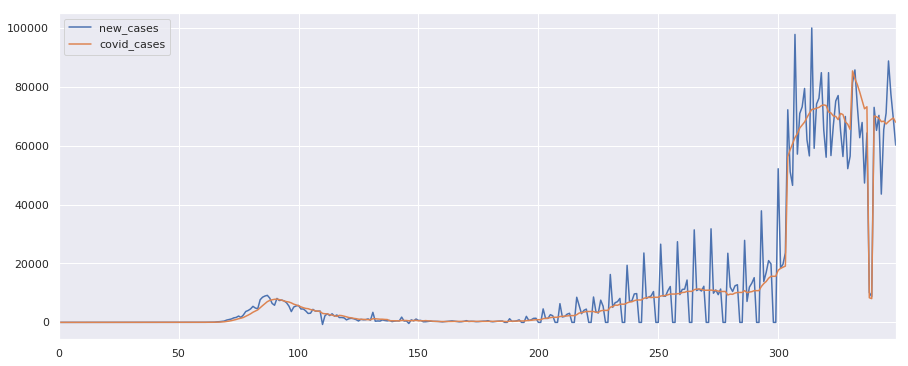

In [17]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [18]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-12-14,2020-12-14,ES,V1,214,1.2.840.10045.4.3.2,e20ac5d1-9c6c-19e8-84f5-a549ff70e28b,2679840,130,0,ES
1,2020-12-14,2020-12-14,ES,V1,214,1.2.840.10045.4.3.2,e7d9ddc9-f08f-b4e0-d1de-1dd6a2c85c51,2679840,129,0,ES
2,2020-12-14,2020-12-14,ES,V1,214,1.2.840.10045.4.3.2,3055368d-2ea9-0e77-4a2d-95875c53f6a6,2679840,129,0,ES
3,2020-12-14,2020-12-14,ES,V1,214,1.2.840.10045.4.3.2,4391421c-a2e6-369b-1f3b-60e67c0c17e0,2679840,128,0,ES
4,2020-12-14,2020-12-14,ES,V1,214,1.2.840.10045.4.3.2,283256dc-c171-8924-486b-7c2f6445aea2,2679840,125,0,ES


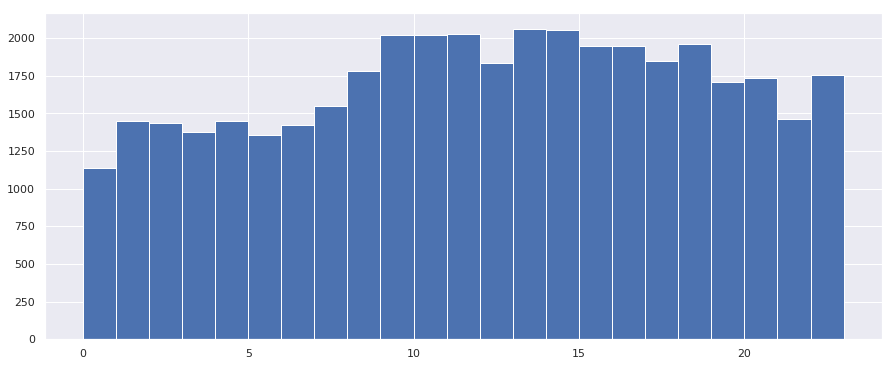

In [19]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

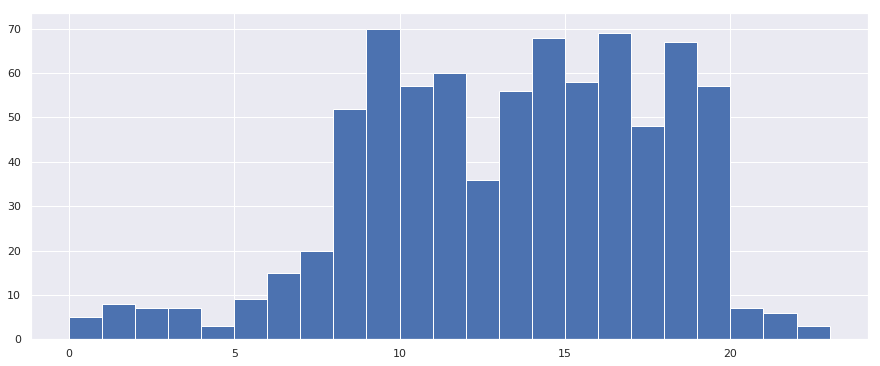

In [20]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [21]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-12-14,ES,e20ac5d1-9c6c-19e8-84f5-a549ff70e28b
1,2020-12-14,ES,e7d9ddc9-f08f-b4e0-d1de-1dd6a2c85c51
2,2020-12-14,ES,3055368d-2ea9-0e77-4a2d-95875c53f6a6
3,2020-12-14,ES,4391421c-a2e6-369b-1f3b-60e67c0c17e0
4,2020-12-14,ES,283256dc-c171-8924-486b-7c2f6445aea2


In [22]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['PT', 'MT', 'EE', 'CH', 'ES@PRE', 'DE', 'ES']

In [23]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                  
region                                  CH    DE   EE     ES ES@PRE   MT  PT
sample_date                                                                 
2020-12-14                             535     0    0    181     75    0   0
2020-12-13                            1019     8   31   1581    716  100  46
2020-12-12                            1548  1336   70   3911   1360  100  61
2020-12-11                            2104  4032  105   7575   1890  100  74
2020-12-10                            2637  6953  137  11327   2335  100  91

In [24]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

<ipython-input-24-4e21708c19d8>:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
<ipython-input-24-4e21708c19d8>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


<ipython-input-24-4e21708c19d8>:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                          
region_x                   CH        DE   EE        ES ES@PRE   MT   PT
region_y                                                               
CH                        NaN  0.000006  0.0  0.000004    0.0  0.0  0.0
DE                   0.000033       NaN  0.0  0.656926    0.0  0.0  0.0
EE                   0.000000  0.000000  NaN  0.000000    0.0  0.0  0.0
ES                   0.000033  0.975654  0.0       NaN    0.0  0.0  0.0
ES@PRE               0.000000  0.000000  0.0  0.000000    NaN  0.0  0.0
MT                   0.000000  0.000000  0.0  0.000000    0.0  NaN  0.0
PT                   0.000000  0.000000  0.0  0.000000    0.0  0.0  NaN

In [25]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['PT', 'MT', 'EE', 'CH', 'ES@PRE', 'DE']

In [26]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-12-14,181
2020-12-13,1581
2020-12-12,3911
2020-12-11,7575
2020-12-10,11327


### Dump API TEKs

In [27]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-12-01,CH,"[c09e960a-0b96-3a34-a7bf-03476cf1ab65, 7707f5f...",2020-12-14,2020-12-14@23
1,2020-12-01,DE,"[04cca124-4e50-7575-e025-c95b13f4ca2b, 296c325...",2020-12-14,2020-12-14@23
2,2020-12-01,EE,"[8e964d2d-3906-d603-137a-5ccdf6c8cc50, a4d89a1...",2020-12-14,2020-12-14@23
3,2020-12-01,ES,"[43c62d48-e2f4-9925-f9f8-2d4cdd246dea, 1853d1b...",2020-12-14,2020-12-14@23
4,2020-12-01,ES@PRE,"[bbb293a7-a4b0-0eb5-e2c2-44b63127e131, 6794ed0...",2020-12-14,2020-12-14@23


### Load TEK Dumps

In [28]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [29]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date
3,ES,2020-12-01,"[43c62d48-e2f4-9925-f9f8-2d4cdd246dea, 1853d1b...",2020-12-14
10,ES,2020-12-02,"[7f8882d6-31fc-d961-fd56-a79f53619091, 3b177a5...",2020-12-14
17,ES,2020-12-03,"[4e2a80d1-14f7-9a11-c89d-65a7e9fa7be0, 6d29453...",2020-12-14
24,ES,2020-12-04,"[1996d78c-172d-0c7b-31a3-9e66f3cf30ba, f05c446...",2020-12-14
31,ES,2020-12-05,"[f8db83db-cdd4-aab3-85d9-120fabb7e2e8, 810ce6f...",2020-12-14


In [30]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-12-14,181
2020-12-13,1581
2020-12-12,3911
2020-12-11,7575
2020-12-10,11327


### Daily New TEKs

In [31]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-09-21,"{610b393d-5916-99b7-7867-5e9d4e4af157, e9828b2..."
2020-09-22,"{610b393d-5916-99b7-7867-5e9d4e4af157, 41a38a7..."
2020-09-23,"{610b393d-5916-99b7-7867-5e9d4e4af157, 41a38a7..."
2020-09-24,"{610b393d-5916-99b7-7867-5e9d4e4af157, 41a38a7..."
2020-09-25,"{610b393d-5916-99b7-7867-5e9d4e4af157, 41a38a7..."


In [32]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-32-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
12,2020-09-22,2020-09-21,55,1
11,2020-09-22,2020-09-20,26,2
10,2020-09-22,2020-09-19,24,3
9,2020-09-22,2020-09-18,21,4
8,2020-09-22,2020-09-17,22,5


In [33]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
31,2020-12-14,2020-12-05,1742,9
24,2020-12-14,2020-12-04,1754,10
17,2020-12-14,2020-12-03,1716,11
10,2020-12-14,2020-12-02,1698,12
3,2020-12-14,2020-12-01,1689,13


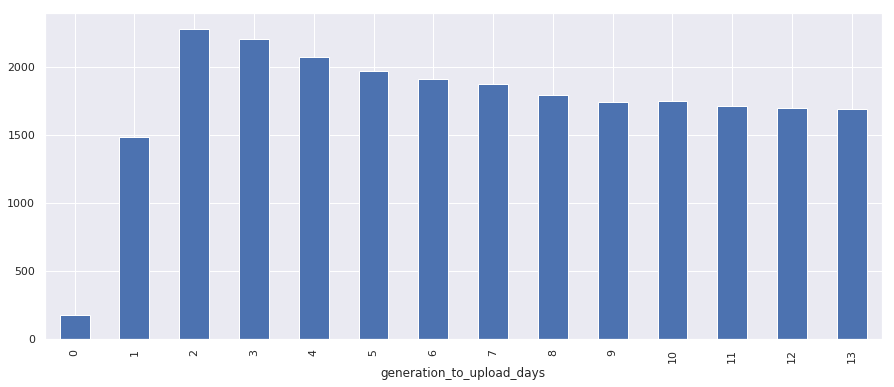

In [34]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [35]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-12-14,181,1485,2282,2203,2075,1972,1912,1875,1794,1742,1754,1716,1698,1689
2020-12-13,96,1421,2712,2408,2246,2177,2122,2062,2044,2014,1976,1971,1931,1922
2020-12-12,208,2402,3729,3385,3217,3041,2974,2924,2899,2858,2833,2791,2734,2744
2020-12-11,258,2908,4215,3893,3664,3580,3500,3427,3349,3309,3270,3205,3193,3140
2020-12-10,207,2665,3754,3416,3244,3191,3132,3069,3036,2979,2955,2914,2871,2889


In [36]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
80,2020-12-10,40322.0
81,2020-12-11,44911.0
82,2020-12-12,38739.0
83,2020-12-13,27102.0
84,2020-12-14,24378.0


In [37]:
shared_teks_uploaded_on_generation_date_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == 0] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
92,2020-12-14,181
92,2020-12-13,96
92,2020-12-12,208
92,2020-12-11,258
92,2020-12-10,207


In [38]:
estimated_shared_diagnoses_df = shared_teks_generation_to_upload_df \
    .groupby(["upload_date"]).shared_teks.max().reset_index() \
    .sort_values(["upload_date"], ascending=False) \
    .rename(columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_diagnoses",
    })
invalid_shared_diagnoses_dates_mask = \
    estimated_shared_diagnoses_df.sample_date_string.isin(invalid_shared_diagnoses_dates)
estimated_shared_diagnoses_df[invalid_shared_diagnoses_dates_mask] = 0
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
83,2020-12-14,2282
82,2020-12-13,2712
81,2020-12-12,3729
80,2020-12-11,4215
79,2020-12-10,3754


### Hourly New TEKs

In [39]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
3,ES,2020-12-01,"[43c62d48-e2f4-9925-f9f8-2d4cdd246dea, 1853d1b...",2020-12-14,2020-12-14@23
10,ES,2020-12-02,"[7f8882d6-31fc-d961-fd56-a79f53619091, 3b177a5...",2020-12-14,2020-12-14@23
17,ES,2020-12-03,"[4e2a80d1-14f7-9a11-c89d-65a7e9fa7be0, 6d29453...",2020-12-14,2020-12-14@23
24,ES,2020-12-04,"[1996d78c-172d-0c7b-31a3-9e66f3cf30ba, f05c446...",2020-12-14,2020-12-14@23
31,ES,2020-12-05,"[f8db83db-cdd4-aab3-85d9-120fabb7e2e8, 810ce6f...",2020-12-14,2020-12-14@23


In [40]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-12-13@22,0
1,2020-12-13@23,0
2,2020-12-14@01,9
3,2020-12-14@02,10
4,2020-12-14@03,0


In [41]:
hourly_summary_df = hourly_new_tek_count_df.copy()
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
datetime_utc,,
2020-12-13 23:00:00,2020-12-13@23,0
2020-12-14 01:00:00,2020-12-14@01,9
2020-12-14 02:00:00,2020-12-14@02,10
2020-12-14 03:00:00,2020-12-14@03,0
2020-12-14 04:00:00,2020-12-14@04,18


### Data Merge

In [42]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-12-14,181,24378.0
1,2020-12-13,1581,27102.0
2,2020-12-12,3911,38739.0
3,2020-12-11,7575,44911.0
4,2020-12-10,11327,40322.0


In [43]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-12-14,181,24378.0,181.0
1,2020-12-13,1581,27102.0,96.0
2,2020-12-12,3911,38739.0,208.0
3,2020-12-11,7575,44911.0,258.0
4,2020-12-10,11327,40322.0,207.0


In [44]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-12-14,181.0,24378.0,181.0,2282.0
1,2020-12-13,1581.0,27102.0,96.0,2712.0
2,2020-12-12,3911.0,38739.0,208.0,3729.0
3,2020-12-11,7575.0,44911.0,258.0,4215.0
4,2020-12-10,11327.0,40322.0,207.0,3754.0


In [45]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-09-22,10799,11300.0,282.0,148.0,NaN,55.0
1,2020-09-23,11289,11314.0,296.0,267.0,4.0,70.0
2,2020-09-24,10653,11223.0,286.0,289.0,17.0,89.0
3,2020-09-25,12272,10920.0,284.0,306.0,14.0,86.0
4,2020-09-26,0,10920.0,339.0,448.0,79.0,110.0


In [46]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df = result_summary_df.merge(source_regions_for_summary_df, how="left")
result_summary_df.set_index(["sample_date", "source_regions"], inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,source_regions,,,,,,
2020-12-14,"ES,DE,DK,HR,IE,IT,LV,NL,PL",60206,67988.0,181.0,24378.0,181.0,2282.0
2020-12-13,"ES,DE,DK,HR,IE,IT,LV,NL,PL",69268,69432.0,1581.0,27102.0,96.0,2712.0
2020-12-12,"ES,DE,DK,HR,IE,IT,LV,NL,PL",77551,68853.0,3911.0,38739.0,208.0,3729.0
2020-12-11,"ES,DE,DK,HR,IE,IT,LV,NL,PL",88796,68208.0,7575.0,44911.0,258.0,4215.0
2020-12-10,"ES,DE,DK,HR,IE,IT,LV,NL,PL",71087,67396.0,11327.0,40322.0,207.0,3754.0


In [47]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,source_regions,,,,,,,,
2020-12-14,"ES,DE,DK,HR,IE,IT,LV,NL,PL",60206,67988,181,24378,181,2282,10.682734,0.033565
2020-12-13,"ES,DE,DK,HR,IE,IT,LV,NL,PL",69268,69432,1581,27102,96,2712,9.993363,0.039060
2020-12-12,"ES,DE,DK,HR,IE,IT,LV,NL,PL",77551,68853,3911,38739,208,3729,10.388576,0.054159
2020-12-11,"ES,DE,DK,HR,IE,IT,LV,NL,PL",88796,68208,7575,44911,258,4215,10.655042,0.061796
2020-12-10,"ES,DE,DK,HR,IE,IT,LV,NL,PL",71087,67396,11327,40322,207,3754,10.741076,0.055701
2020-12-09,"ES,DE,DK,HR,IE,IT,LV,NL,PL",65435,68341,14600,43004,117,4014,10.713503,0.058735
2020-12-08,"ES,DE,DK,HR,IE,IT,LV,NL,PL",43571,68184,17915,30102,121,2641,11.397955,0.038733
2020-12-07,"ES,DE,DK,HR,IE,IT,LV,NL,PL",70313,69374,20534,20104,116,1823,11.027976,0.026278
2020-12-06,"ES,DE,DK,HR,IE,IT,LV,NL,PL",65216,69827,21387,17206,152,1707,10.079672,0.024446


In [48]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,source_regions,,,,,,
2020-12-14,"ES,DE,DK,HR,IE,IT,LV,NL,PL",478402,57090,248558,23347,10.646250,0.048802
2020-12-13,"ES,DE,DK,HR,IE,IT,LV,NL,PL",479788,77443,244284,22888,10.673016,0.047704
2020-12-12,"ES,DE,DK,HR,IE,IT,LV,NL,PL",480183,97249,234388,21883,10.710963,0.045572
2020-12-11,"ES,DE,DK,HR,IE,IT,LV,NL,PL",481436,115993,301868,18154,16.628181,0.037708
2020-12-10,"ES,DE,DK,HR,IE,IT,LV,NL,PL",421291,133389,257751,14127,18.245275,0.033533


In [49]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 479788,
 'shared_teks_by_generation_date': 77443,
 'shared_teks_by_upload_date': 244284,
 'shared_diagnoses': 22888,
 'teks_per_shared_diagnosis': 10.67301642782244,
 'shared_diagnoses_per_covid_case': 0.04770440277789357}

## Report Results

In [50]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "source_regions": "Source Countries",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases in Source Countries (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [51]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [52]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,,COVID-19 Cases in Source Countries (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)
Sample Date (UTC),Source Countries,,,,,,,
2020-12-14,"ES,DE,DK,HR,IE,IT,LV,NL,PL",67988,181,24378,181,2282,10.682734,0.033565
2020-12-13,"ES,DE,DK,HR,IE,IT,LV,NL,PL",69432,1581,27102,96,2712,9.993363,0.039060
2020-12-12,"ES,DE,DK,HR,IE,IT,LV,NL,PL",68853,3911,38739,208,3729,10.388576,0.054159
2020-12-11,"ES,DE,DK,HR,IE,IT,LV,NL,PL",68208,7575,44911,258,4215,10.655042,0.061796
2020-12-10,"ES,DE,DK,HR,IE,IT,LV,NL,PL",67396,11327,40322,207,3754,10.741076,0.055701
...,...,...,...,...,...,...,...,...
2020-09-26,ES,10920,339,448,79,110,4.072727,0.010073
2020-09-25,ES,10920,284,306,14,86,3.558140,0.007875
2020-09-24,ES,11223,286,289,17,89,3.247191,0.007930


### Daily Summary Plots

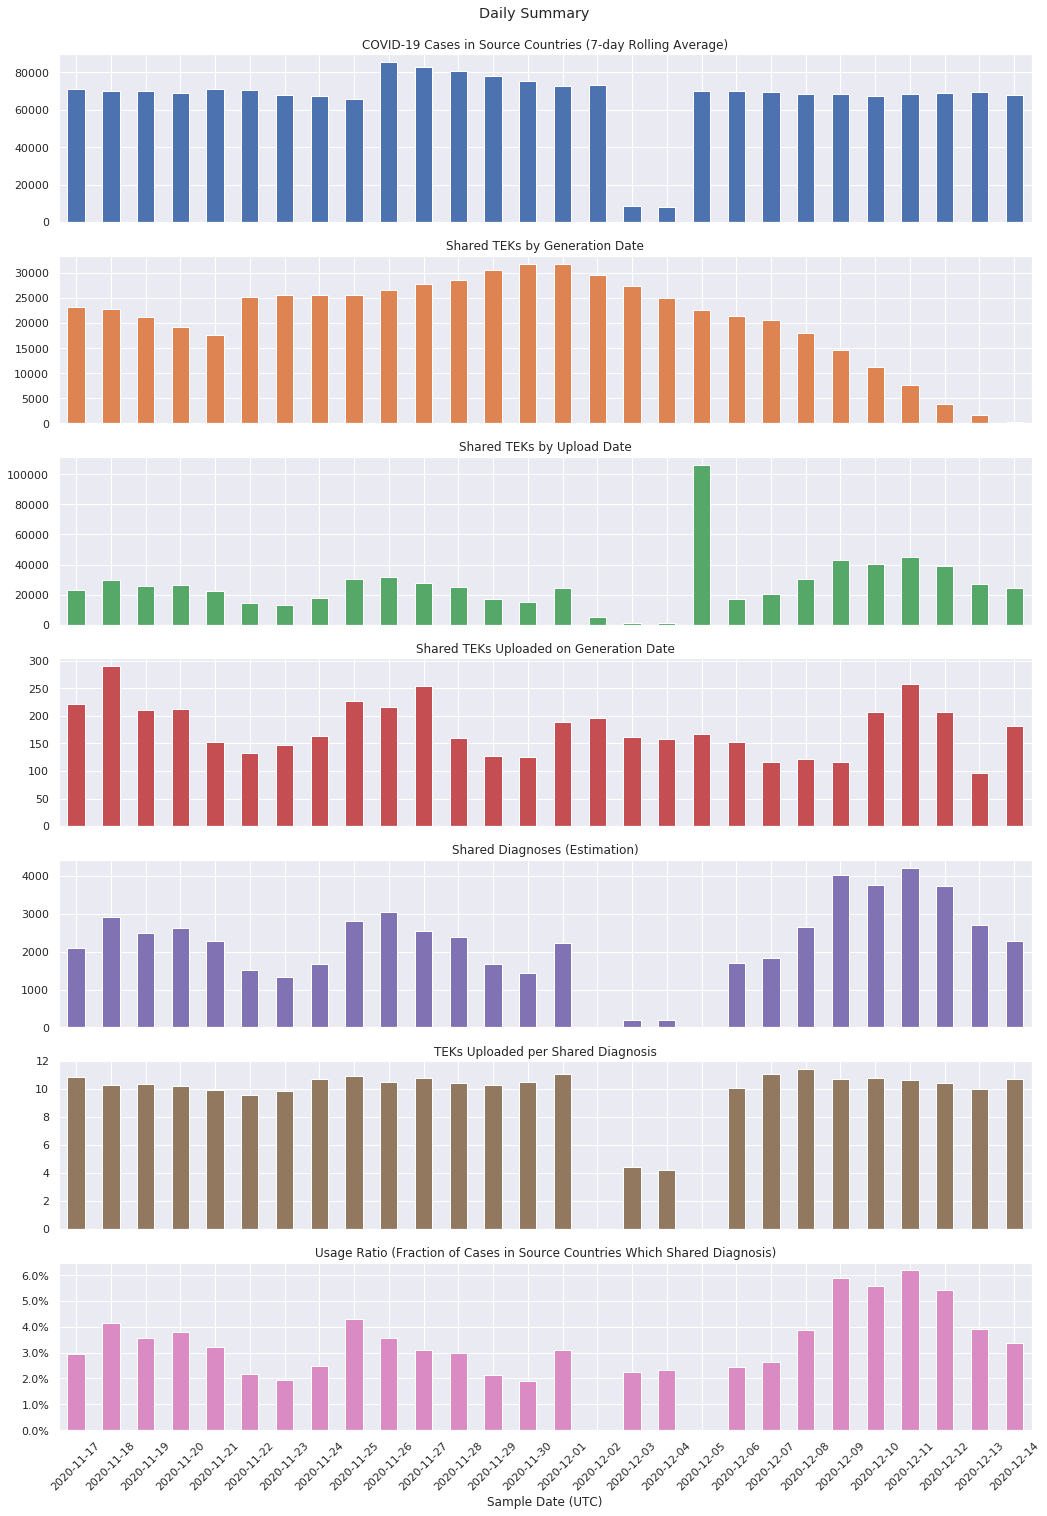

In [53]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .droplevel(level=["source_regions"]) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [54]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-12-14,181,1485,2282,2203,2075,1972,1912,1875,1794,1742,1754,1716,1698,1689
2020-12-13,96,1421,2712,2408,2246,2177,2122,2062,2044,2014,1976,1971,1931,1922
2020-12-12,208,2402,3729,3385,3217,3041,2974,2924,2899,2858,2833,2791,2734,2744
2020-12-11,258,2908,4215,3893,3664,3580,3500,3427,3349,3309,3270,3205,3193,3140
2020-12-10,207,2665,3754,3416,3244,3191,3132,3069,3036,2979,2955,2914,2871,2889
2020-12-09,117,2841,4014,3601,3519,3436,3342,3276,3238,3192,3134,3115,3107,3072
2020-12-08,121,2286,2641,2575,2496,2411,2335,2266,2246,2193,2165,2138,2133,2096
2020-12-07,116,1339,1823,1765,1689,1604,1569,1519,1525,1462,1448,1430,1402,1413
2020-12-06,152,1170,1707,1523,1398,1355,1310,1280,1275,1247,1238,1188,1190,1173


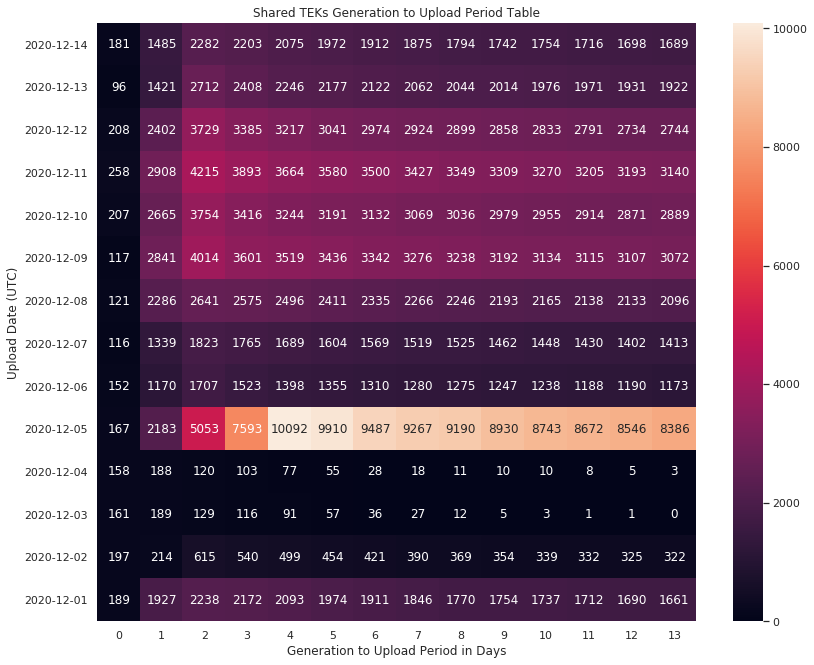

In [55]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(12, 1 + 0.6 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

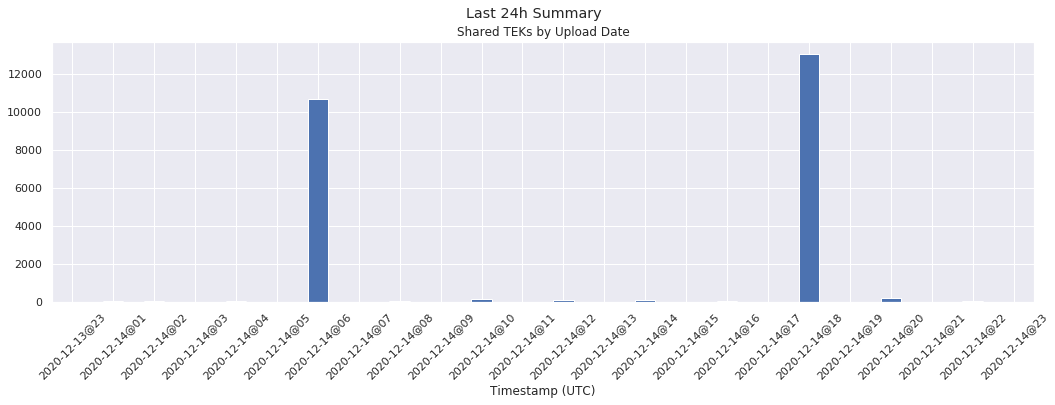

In [56]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [57]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [58]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index.get_level_values("sample_date") == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.item()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.item()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.item()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.item()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.item()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)
if len(report_source_regions) == 1:
    display_brief_source_regions = report_source_regions[0]
else:
    display_brief_source_regions = f"{len(report_source_regions)} 🇪🇺"

<ipython-input-58-bd16b454de40>:49: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.covid_cases.item()
<ipython-input-58-bd16b454de40>:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_generation_date.item()
<ipython-input-58-bd16b454de40>:53: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_upload_date.item()
<ipython-input-58-bd16b454de40>:55: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_diagnoses.item()
<ipython-input-58-bd16b454de40>:57: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
<ipython-input-58-bd16b454de40>:59: FutureWarning: `item` has been deprecated and 

In [59]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [60]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [61]:
def generate_summary_api_results(df: pd.DataFrame) -> list:
    api_df = df.reset_index().copy()
    api_df["sample_date_string"] = \
        api_df["sample_date"].dt.strftime("%Y-%m-%d")
    api_df["source_regions"] = \
        api_df["source_regions"].apply(lambda x: x.split(","))
    return api_df.to_dict(orient="records")

summary_api_results = \
    generate_summary_api_results(df=result_summary_df)
today_summary_api_results = \
    generate_summary_api_results(df=extraction_date_result_summary_df)[0]

summary_results = dict(
    backend_identifier=report_backend_identifier,
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=0,
    ),
    today=today_summary_api_results,
    last_7_days=last_7_days_summary,
    daily_results=summary_api_results)

summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [62]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [63]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Source Countries: {display_brief_source_regions}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Last 7 Days:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)